In [37]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
#globals
TOTAL_FEATURES = 8
BACK_CANDLES = 100
FUTURE_DAYS = 10

def create_stock_dictionary():
    dictionary = {}
    current_directory = os.getcwd()
    folder_name = 'S&P500'
    folder_path = os.path.join(current_directory, folder_name)

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            name = file_name.split("_")[0]
            file_path = os.path.join(folder_path, file_name)
            dictionary[name] = pd.read_csv(file_path)
            
    return dictionary

In [38]:
import random
stock_data = create_stock_dictionary()


In [39]:
from sklearn.model_selection import train_test_split
n_days = BACK_CANDLES
m_days = FUTURE_DAYS
stock_data_training = {}
stock_data_testing = {}

#split data for training
for i in stock_data.keys():
    #add more features here
    stock_data[i].rename(columns = {'Datetime':'Date'}, inplace = True)
    stock_data[i]["TargetNextClose"] = stock_data[i]["Adj Close"].shift(-1)
    stock_data[i].drop(['Close'], axis=1, inplace=True)
    
    #change scaling algorithm
    scaler = MinMaxScaler()
    for k in range(1, stock_data[i].shape[1]):
        column_data = stock_data[i].iloc[:, k].values.reshape(-1, 1)
        stock_data[i].iloc[:, k] = scaler.fit_transform(column_data)
    
    stock_data_training[i], stock_data_testing[i] = train_test_split(stock_data[i], test_size=0.2, shuffle=False)


C:\Users\Rober\AppData\Local\Temp\ipykernel_19016\4098690617.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.29658535 0.12931719 0.14133768 ... 0.05502429 0.04660199 0.33436724]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  stock_data[i].iloc[:, k] = scaler.fit_transform(column_data)
C:\Users\Rober\AppData\Local\Temp\ipykernel_19016\4098690617.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.29703548 0.1582845  0.12720318 ... 0.0869435  0.07265305 0.38125801]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  stock_data[i].iloc[:, k] = scaler.fit_transform(column_data)
C:\Users\Rober\AppData\Local\Temp\ipykernel_19016\4098690617.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Val

In [40]:
stock_data_training['AAPL'].head(30)


,Date,Open,High,Low,Adj Close,Volume,TargetNextClose
0,2022-04-07 09:30:00-04:00,0.627604,0.645420,0.629669,0.640124,0.297035,0.623686
1,2022-04-07 10:30:00-04:00,0.640066,0.635378,0.624160,0.623686,0.158285,0.624225
2,2022-04-07 11:30:00-04:00,0.623562,0.623929,0.621271,0.624225,0.127203,0.628133
3,2022-04-07 12:30:00-04:00,0.623966,0.621656,0.613814,0.628133,0.145370,0.634735
4,2022-04-07 13:30:00-04:00,0.628075,0.633570,0.626579,0.634735,0.118171,0.647834
5,2022-04-07 14:30:00-04:00,0.634340,0.645956,0.635851,0.647834,0.147731,0.641337
6,2022-04-07 15:30:00-04:00,0.647813,0.648366,0.641091,0.641337,0.159603,0.615872
7,2022-04-08 09:30:00-04:00,0.631241,0.625469,0.605079,0.615872,0.339201,0.624225
8,2022-04-08 10:30:00-04:00,0.615613,0.621585,0.610723,0.624225,0.199996,0.634398
9,2022-04-08 11:30:00-04:00,0.624370,0.627076,0.620344,0.634398,0.142385,0.623148


In [41]:
stock_data_testing['AAPL'].head(20)

,Date,Open,High,Low,Adj Close,Volume,TargetNextClose
2678,2023-10-17 14:30:00-04:00,0.707499,0.701660,0.701357,0.703315,0.110444,0.708300
2679,2023-10-17 15:30:00-04:00,0.703322,0.701125,0.702432,0.708300,0.110160,0.701293
2680,2023-10-18 09:30:00-04:00,0.687155,0.704807,0.688659,0.701293,0.204863,0.702776
2681,2023-10-18 10:30:00-04:00,0.700965,0.698714,0.693161,0.702776,0.124333,0.703988
2682,2023-10-18 11:30:00-04:00,0.702649,0.704205,0.704919,0.703988,0.093696,0.708030
2683,2023-10-18 12:30:00-04:00,0.703861,0.702062,0.699476,0.708030,0.093812,0.702304
2684,2023-10-18 13:30:00-04:00,0.707903,0.698849,0.699409,0.702304,0.079417,0.691322
2685,2023-10-18 14:30:00-04:00,0.702042,0.695969,0.693496,0.691322,0.091973,0.689989
2686,2023-10-18 15:30:00-04:00,0.691197,0.684922,0.684493,0.689989,0.112858,0.695769
2687,2023-10-19 09:30:00-04:00,0.693352,0.701527,0.694370,0.695769,0.193757,0.696307


In [53]:
#code that lets you select which stocks you want to train on, so you can use other stocks to train
vals = stock_data_training.values()
training_vals = ['AAPL', 'MSFT', 'YUM', 'XYL', 'GOOG']
training_df_list = []
for key in stock_data_training.keys():
    for item in training_vals:
        if(key == item):
            training_df_list.append(stock_data_training[key])
            

stacked_stock_data = pd.concat(training_df_list, ignore_index=True, axis=0)
stacked_stock_data = stacked_stock_data.dropna()
stacked_stock_data.iloc[99:120, -1]



99     0.508086
100    0.523983
101    0.519039
102    0.530181
103    0.531999
104    0.519402
105    0.504446
106    0.482630
107    0.478712
108    0.476960
109    0.460523
110    0.445702
111    0.428725
112    0.421585
113    0.425835
114    0.402413
115    0.394099
116    0.430613
117    0.449340
118    0.448397
119    0.468580
Name: TargetNextClose, dtype: float64

In [46]:
xs, ys = [], []
#for actuallly training data
for i in range(len(stacked_stock_data) - n_days - m_days + 1): 

    v = stacked_stock_data.iloc[i:(i + n_days), :-1]

    if v['Date'].iloc[-1] <= v['Date'].iloc[0]: 
        continue

    xs.append(v.iloc[:, 1:].to_numpy())
    ys.append(stacked_stock_data.iloc[i + n_days:i + n_days + m_days, len(stacked_stock_data.columns) - 1])
xs = np.array(xs)
ys = np.array(ys)


array([[0.52398289, 0.51903931, 0.53018057, ..., 0.47871207, 0.47696045,
        0.46052281],
       [0.51903931, 0.53018057, 0.53199941, ..., 0.47696045, 0.46052281,
        0.44570193],
       [0.53018057, 0.53199941, 0.51940176, ..., 0.46052281, 0.44570193,
        0.42872544],
       ...,
       [0.35736922, 0.34838866, 0.36053866, ..., 0.37770722, 0.39038559,
        0.37849958],
       [0.34838866, 0.36053866, 0.35789739, ..., 0.39038559, 0.37849958,
        0.36687795],
       [0.36053866, 0.35789739, 0.36450067, ..., 0.37849958, 0.36687795,
        0.37295285]])

In [54]:
xs[0]

array([[0.62760368, 0.64542048, 0.62966947, 0.64012404, 0.29703548],
       [0.64006634, 0.63537763, 0.62416015, 0.6236864 , 0.1582845 ],
       [0.62356171, 0.62392884, 0.62127119, 0.62422525, 0.12720318],
       [0.62396589, 0.62165637, 0.61381361, 0.62813267, 0.14536972],
       [0.62807529, 0.63356999, 0.62657896, 0.63473453, 0.11817108],
       [0.63434023, 0.64595601, 0.63585069, 0.64783361, 0.14773071],
       [0.64781333, 0.6483664 , 0.64109121, 0.6413366 , 0.15960273],
       [0.63124127, 0.62546861, 0.60507928, 0.61587177, 0.33920082],
       [0.61561264, 0.62158547, 0.6107229 , 0.62422525, 0.19999643],
       [0.62437007, 0.62707561, 0.62034401, 0.63439778, 0.14238512],
       [0.63420537, 0.62653865, 0.62597431, 0.62314756, 0.09115187],
       [0.62302412, 0.61502018, 0.61354481, 0.61142695, 0.1177756 ],
       [0.61143601, 0.61636319, 0.61287291, 0.62206965, 0.14265161],
       [0.62207967, 0.61489023, 0.61341051, 0.6139855 , 0.14947749],
       [0.5917652 , 0.58690421, 0.

In [56]:
X_test = []
Y_test = []

for key, df in stock_data_testing.items():
    if(key == 'WY'):
        if len(df) >= n_days + m_days:
            for i in range(len(df) - n_days - m_days + 1):
                X_test.append(df.iloc[i:i+n_days, 1:-1].to_numpy())

            for i in range(len(df) - n_days - m_days + 1):
                Y_test.append(df.iloc[i+n_days:i+n_days+m_days, -1].to_numpy())

X_test = np.array(X_test)
Y_test = np.array(Y_test)

Y_test

array([[0.20604025, 0.20234896, 0.20302011, ..., 0.17785233, 0.17416103,
        0.18020131],
       [0.20234896, 0.20302011, 0.20033562, ..., 0.17416103, 0.18020131,
        0.18154362],
       [0.20302011, 0.20033562, 0.20100664, ..., 0.18020131, 0.18154362,
        0.18221478],
       ...,
       [0.48859066, 0.47181214, 0.45234899, ..., 0.47684575, 0.47550343,
        0.47986576],
       [0.47181214, 0.45234899, 0.46510058, ..., 0.47550343, 0.47986576,
        0.47315445],
       [0.45234899, 0.46510058, 0.48594623, ..., 0.47986576, 0.47315445,
               nan]])

In [58]:
from keras.layers import LSTM
from keras.layers import Dense
import tensorflow as tf
from keras import Sequential
from keras import optimizers
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Dense, GRU, LeakyReLU
num_features = 5
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_days, num_features), return_sequences=True))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(m_days))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(xs, ys, epochs=5, batch_size=32, validation_split=0.2)



Epoch 1/5
323/323 ━━━━━━━━━━━━━━━━━━━━ 173s 499ms/step - loss: 0.0219 - val_loss: 0.0027
Epoch 2/5
323/323 ━━━━━━━━━━━━━━━━━━━━ 150s 465ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 3/5
323/323 ━━━━━━━━━━━━━━━━━━━━ 149s 463ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 4/5
323/323 ━━━━━━━━━━━━━━━━━━━━ 179s 554ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 5/5
323/323 ━━━━━━━━━━━━━━━━━━━━ 149s 461ms/step - loss: 0.0014 - val_loss: 0.0019


In [63]:
y_pred = model.predict(X_test)


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step


In [67]:
y_pred.shape

(561, 10)

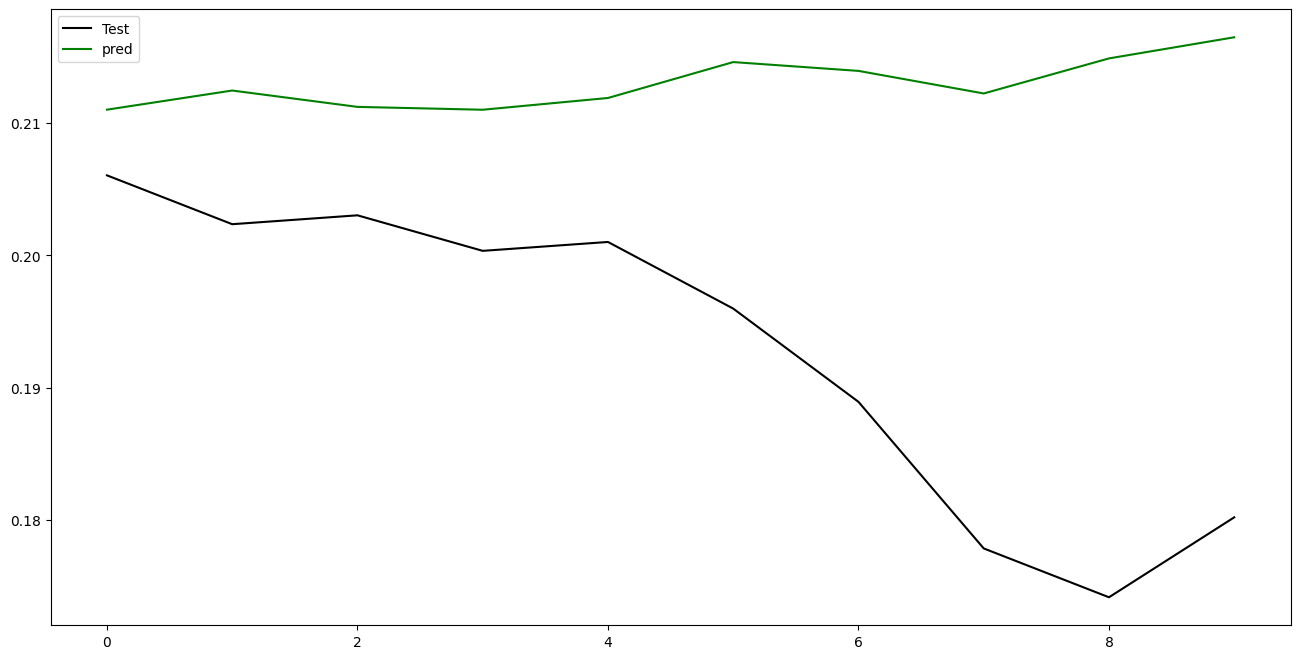

In [72]:
plt.figure(figsize=(16,8))
plt.plot(Y_test[0], color = 'black', label = 'Test')
plt.plot(y_pred[0], color = 'green', label = 'pred')
plt.legend()
plt.show()